# MIDI Music Generation - Language Model Approach

**Key insight**: Treat MIDI as a sequence of tokens (like text),

Using the proven tokenization from SkyTNT's midi-model:
- Each MIDI event → 8 tokens: `[event_type, time1, time2, track, channel, pitch, velocity, duration]`
- Vocabulary: ~3400 tokens
- Task: Predict next token (standard language modeling)

Same approach as successful music models (MuseNet, Music Transformer), but trained on a custom MIDI corpus.

## 1. Setup

In [12]:
import setproctitle # we installed this package already, see above
setproctitle.setproctitle('midi-gen sprec1')

In [13]:
import random
import time
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print(f"Using CUDA: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
    print("Using Apple Silicon MPS")
else:
    DEVICE = torch.device('cpu')
    print("Using CPU")

print(f"PyTorch version: {torch.__version__}")

Using Apple Silicon MPS
PyTorch version: 2.9.1


## 2. Initialize Tokenizer

The Tokenizer is 

In [14]:
from midi_tokenizer import MIDITokenizer

tokenizer = MIDITokenizer()

VOCAB_SIZE = tokenizer.vocab_size
PAD_ID = tokenizer.pad_id
BOS_ID = tokenizer.bos_id
EOS_ID = tokenizer.eos_id
MAX_TOKEN_SEQ = tokenizer.max_token_seq  # 8 tokens per event

print(f"Vocabulary size: {VOCAB_SIZE}")
print(f"Tokens per event: {MAX_TOKEN_SEQ}")
print(f"Special tokens: PAD={PAD_ID}, BOS={BOS_ID}, EOS={EOS_ID}")
print(f"\nEvent types: {list(tokenizer.events.keys())}")

Vocabulary size: 3406
Tokens per event: 8
Special tokens: PAD=0, BOS=1, EOS=2

Event types: ['note', 'patch_change', 'control_change', 'set_tempo', 'time_signature', 'key_signature']


## 3. Load and Tokenize Dataset

In [15]:
DATA_DIR = Path("./midi_data")
ADL_DIR = DATA_DIR / "adl-piano-midi"

# Get all MIDI files
all_midi_files = list(ADL_DIR.rglob("*.mid"))
print(f"Found {len(all_midi_files)} MIDI files")

# Shuffle and split
random.shuffle(all_midi_files)
n = len(all_midi_files)
train_files = all_midi_files[:int(n * 0.8)]
val_files = all_midi_files[int(n * 0.8):int(n * 0.9)]
test_files = all_midi_files[int(n * 0.9):]

print(f"Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")

Found 11076 MIDI files
Train: 8860, Val: 1108, Test: 1108


In [16]:
# Limit for faster iteration (set to None for full dataset)
MAX_FILES = None  # Use all files

def tokenize_files(files, max_files=None):
    """Tokenize MIDI files and return flattened sequences."""
    if max_files:
        files = files[:max_files]
    
    sequences = []
    for f in tqdm(files, desc="Tokenizing"):
        tokens = tokenizer.midi_file_to_tokens(f)
        if tokens is not None and len(tokens) > 10:  # Skip very short files
            # Flatten: (num_events, 8) -> (num_events * 8,)
            flat = tokenizer.flatten_tokens(tokens)
            sequences.append(flat)
    return sequences

print("Tokenizing training data...")
train_sequences = tokenize_files(train_files, MAX_FILES)
print(f"Tokenized {len(train_sequences)} training files")

print("\nTokenizing validation data...")
val_max = MAX_FILES // 4 if MAX_FILES else None
val_sequences = tokenize_files(val_files, val_max)
print(f"Tokenized {len(val_sequences)} validation files")

# Stats
total_tokens = sum(len(s) for s in train_sequences)
avg_len = total_tokens / len(train_sequences) if train_sequences else 0
print(f"\nTotal training tokens: {total_tokens:,}")
print(f"Average sequence length: {avg_len:.0f} tokens")

Tokenizing training data...


Tokenizing:   0%|          | 0/8860 [00:00<?, ?it/s]

Tokenized 8709 training files

Tokenizing validation data...


Tokenizing:   0%|          | 0/1108 [00:00<?, ?it/s]

Tokenized 1095 validation files

Total training tokens: 80,817,152
Average sequence length: 9280 tokens


## 4. Create Dataset

In [17]:
SEQUENCE_LENGTH = 512  # Context window (tokens)
STRIDE = 256  # Overlap between sequences

class TokenSequenceDataset(Dataset):
    """Dataset for next-token prediction."""
    
    def __init__(self, sequences, seq_length, stride):
        self.samples = []
        
        for seq in sequences:
            # Create sliding windows
            for i in range(0, len(seq) - seq_length, stride):
                self.samples.append(seq[i:i + seq_length + 1])  # +1 for target
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        x = torch.LongTensor(sample[:-1])  # Input
        y = torch.LongTensor(sample[1:])   # Target (shifted by 1)
        return x, y

train_dataset = TokenSequenceDataset(train_sequences, SEQUENCE_LENGTH, STRIDE)
val_dataset = TokenSequenceDataset(val_sequences, SEQUENCE_LENGTH, STRIDE)

print(f"Train samples: {len(train_dataset):,}")
print(f"Val samples: {len(val_dataset):,}")

# Check a sample
x, y = train_dataset[0]
print(f"\nSample input shape: {x.shape}")
print(f"Sample target shape: {y.shape}")
print(f"First 16 tokens: {x[:16].tolist()}")

Train samples: 302,616
Val samples: 39,301

Sample input shape: torch.Size([512])
Sample target shape: torch.Size([512])
First 16 tokens: [1, 0, 0, 0, 0, 0, 0, 0, 7, 9, 137, 2201, 3372, 3386, 0, 0]


In [18]:
BATCH_SIZE = 32 if DEVICE.type in ('mps', 'cuda') else 16
NUM_WORKERS = 0 if DEVICE.type == 'mps' else 4

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train batches: 9457
Val batches: 1229


## 5. Model Architecture

We use a simple Transformer decoder (GPT-style) for language modeling.
This is simpler and more proven than Mamba for this task size.

In [19]:
# Import model from shared module
import sys
sys.path.insert(0, str(Path("./midi-model")))
from model import MusicGPT

# Create model
model = MusicGPT(
    vocab_size=VOCAB_SIZE,
    d_model=256,
    n_heads=8,
    n_layers=6,
    max_seq_len=SEQUENCE_LENGTH + 64,
    dropout=0.1,
    tokens_per_event=MAX_TOKEN_SEQ  # 8
).to(DEVICE)

total_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {total_params:,}")
print(f"Device: {DEVICE}")
print(f"Position-in-event embedding: enabled (0-7)")

Model parameters: 8,217,422
Device: mps
Position-in-event embedding: enabled (0-7)


## 6. Training

In [20]:
NUM_EPOCHS = 50
LEARNING_RATE = 3e-4
GRAD_CLIP = 1.0
EARLY_STOPPING_PATIENCE = 5

criterion = nn.CrossEntropyLoss(ignore_index=PAD_ID)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

print(f"Epochs: {NUM_EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Loss: CrossEntropy (ignoring PAD)")

Epochs: 50
Learning rate: 0.0003
Loss: CrossEntropy (ignoring PAD)


In [21]:
def train_epoch(model, loader, criterion, optimizer, device, grad_clip):
    model.train()
    total_loss = 0.0
    
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        logits = model(x)
        
        # Reshape for cross entropy: (batch * seq_len, vocab) vs (batch * seq_len)
        loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)


def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))
            total_loss += loss.item()
    
    return total_loss / len(loader)

In [22]:
# Training loop
train_losses, val_losses = [], []
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_path = DATA_DIR / "best_model_lm.pt"

print(f"Training MusicGPT on {DEVICE}...")
print(f"Saving best model to: {best_model_path}")
print(f"Position-in-event embedding: enabled\n")

total_start = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    
    train_loss = train_epoch(model, train_loader, criterion, optimizer, DEVICE, GRAD_CLIP)
    val_loss = validate(model, val_loader, criterion, DEVICE)
    
    scheduler.step(val_loss)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Calculate perplexity (more interpretable for LM)
    train_ppl = np.exp(train_loss)
    val_ppl = np.exp(val_loss)
    
    # Check for improvement
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'vocab_size': VOCAB_SIZE,
            'sequence_length': SEQUENCE_LENGTH,
            'tokens_per_event': MAX_TOKEN_SEQ,  # NEW: save structure info
        }, best_model_path)
        marker = " *"
    else:
        epochs_without_improvement += 1
        marker = ""
    
    # Log
    lr = optimizer.param_groups[0]['lr']
    elapsed = time.time() - epoch_start
    print(f"Epoch {epoch+1:3d}/{NUM_EPOCHS} | "
          f"Train: {train_loss:.4f} (ppl {train_ppl:.1f}) | "
          f"Val: {val_loss:.4f} (ppl {val_ppl:.1f}) | "
          f"LR: {lr:.6f} | {elapsed:.1f}s{marker}")
    
    # Early stopping
    if epochs_without_improvement >= EARLY_STOPPING_PATIENCE:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

total_time = time.time() - total_start
print(f"\nDone! Total: {total_time/60:.1f} min")
print(f"Best val loss: {best_val_loss:.4f} (perplexity: {np.exp(best_val_loss):.1f})")

Training MusicGPT on mps...
Saving best model to: midi_data/best_model_lm.pt
Position-in-event embedding: enabled



KeyboardInterrupt: 

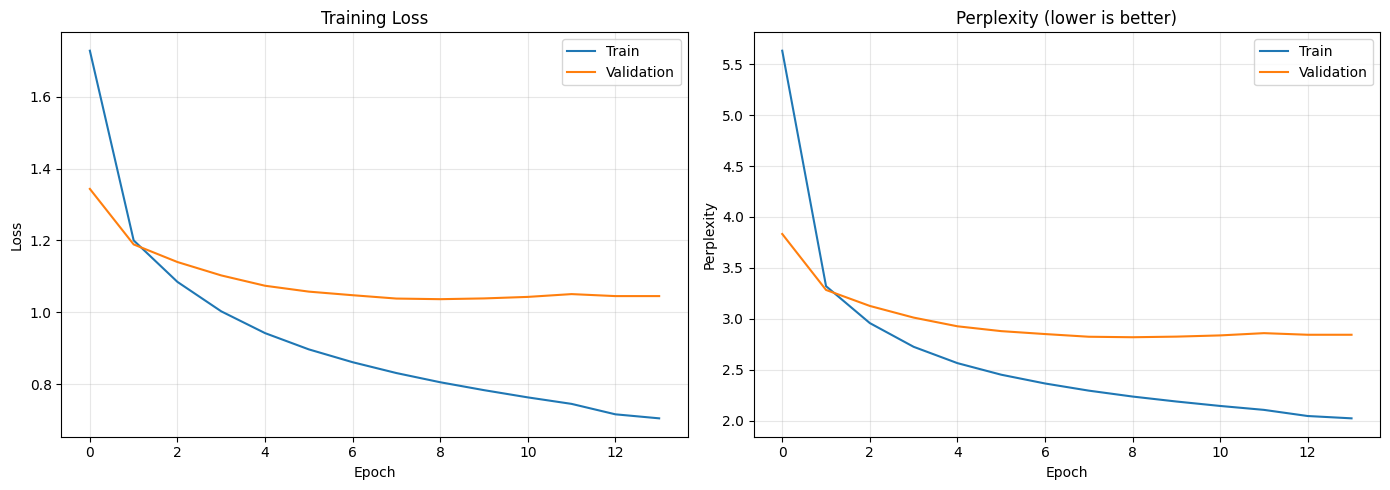


Model saved to: midi_data/best_model_lm.pt
Use midi_lm_generation.ipynb to generate music!


In [11]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(train_losses, label='Train')
ax1.plot(val_losses, label='Validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot([np.exp(l) for l in train_losses], label='Train')
ax2.plot([np.exp(l) for l in val_losses], label='Validation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity')
ax2.set_title('Perplexity (lower is better)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nModel saved to: {best_model_path}")
print("Use midi_lm_generation.ipynb to generate music!")